Here we produce two two-body system catalogs from filtering the Value Added Catalog:
* master catalog of samples produced from a cut on the log-evidence ratio
* master catalog of samples produced from a cut on $K$, i.e. from parameter estimation

In [1]:
import os
import shutil

import astropy.table as at
from astropy.constants import G
import astropy.units as u
import h5py
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
from tqdm import tqdm
import thejoker as tj
import tables as tb

from hq.config import Config
from hq.data import get_rvdata

In [27]:
def fast_mf(P, K, e):
    """Binary mass function."""
    mf_circ = P * K**3 / (2*np.pi * G)
    return mf_circ.to(u.Msun) * (1 - e**2)**1.5

In [3]:
c = Config.from_run_name('dr16')

In [4]:
metadata = at.QTable.read(c.metadata_path)

In [5]:
allstar, allvisit = c.load_alldata()

In [6]:
os.makedirs('../catalogs', exist_ok=True)

Copy big results files to node:

In [9]:
node_paths = dict()
paths = [c.joker_results_path, c.mcmc_results_path, os.path.join(c.run_path, 'thejoker-control.hdf5')]
path_names = ['joker_results', 'mcmc_results', 'control_results']
for name, path in zip(path_names, paths):
    basename = os.path.split(path)[1]
    new_path = f'/dev/shm/{basename}'
    node_paths[name] = new_path
    if not os.path.exists(new_path):
        shutil.copy2(path, new_path)

# Evidence ratio catalog

First produce the sub-selected metadata file:

In [118]:
ev_ratio = np.array(metadata['kepler_ln_evidence'] - metadata['constant_ln_evidence'])
ll_ratio = np.array(metadata['max_unmarginalized_ln_likelihood'] - metadata['robust_constant_ln_likelihood'])

In [137]:
# mask = (ev_ratio > 3) & (ll_ratio > 3)
mask = (ev_ratio > 3) & (ll_ratio > 1)
mask.sum()

22979

In [138]:
((ev_ratio > 5) != (ll_ratio > 5)).sum()

10459

In [139]:
(ev_ratio > 3).sum(), (ll_ratio > 3).sum()

(26536, 26036)

In [145]:
# apogee_ids = metadata[mask]['APOGEE_ID']
# for apid in apogee_ids[10:20]:
#     visits = allvisit[allvisit['APOGEE_ID'] == apid]
#     data = get_rvdata(visits)
    
#     plt.figure()
#     _ = data.plot()
#     plt.title('r={:.2f} r2={:.2f}'.format(ratio[metadata['APOGEE_ID'] == apid][0],
#                                           ratio2[metadata['APOGEE_ID'] == apid][0]))

In [147]:
metadata[mask].write('../catalogs/evidence_ratio_metadata.fits', overwrite=True)

Now collect all samplings:

In [151]:
evidance_catalog_samples_file = '../catalogs/evidence_ratio_samples.hdf5'

In [209]:
with tb.open_file(evidance_catalog_samples_file, 'w') as cat_f:
    with tb.open_file(c.mcmc_results_path, 'r') as mcmc_f, tb.open_file(c.joker_results_path, 'r') as joker_f:
        table = None
        for i, row in enumerate(tqdm(metadata[mask])):
            apid = row['APOGEE_ID']

            if row['mcmc_success']:
                f = mcmc_f
            else:
                f = joker_f
            
            if table is None:
                table = at.Table(f.root[f'{apid}/samples'].read())
                table['APOGEE_ID'] = np.array([apid] * len(table)).astype('S18')
                table['m_f'] = fast_mf(table['P']*u.day, table['K']*u.km/u.s, table['e']).to_value(u.Msun)
                cat_f.create_table('/', 'samples', obj=table.as_array())
                
            else:
                table = at.Table(f.root[f'{apid}/samples'].read())
                table['APOGEE_ID'] = np.array([apid] * len(table)).astype('S18')
                table['m_f'] = fast_mf(table['P']*u.day, table['K']*u.km/u.s, table['e']).to_value(u.Msun)
                cat_f.root['samples'].append(table.as_array())

100%|██████████| 22979/22979 [06:56<00:00, 55.22it/s] 


# K cut catalog

Here we make a cut on the 5th percentile sample in lnK, motivated by the control sample:

In [10]:
with h5py.File(node_paths['mcmc_results'], mode='r') as mcmc_f:
    mcmc_apogee_ids = [key for key in mcmc_f.keys()]

In [12]:
percentiles = [1, 5, 50, 95, 99]

percentile_apogee_ids = []
control_percentiles = []
apogee_percentiles = []
with tb.open_file(node_paths['control_results'], mode='r') as control_f:
    with tb.open_file(node_paths['joker_results'], mode='r') as joker_f:
        for apid in tqdm(metadata['APOGEE_ID'][~metadata['mcmc_success']]):
            try:
                control_lnK = np.log10(control_f.get_node(f'/{apid}/samples').read(field='K'))
                joker_lnK = np.log10(joker_f.get_node(f'/{apid}/samples').read(field='K'))
            except:
                print(apid)
                continue
            
            control_percentiles.append(np.percentile(control_lnK, percentiles))
            apogee_percentiles.append(np.percentile(joker_lnK, percentiles))
            percentile_apogee_ids.append(apid)
            
    with tb.open_file(node_paths['mcmc_results'], mode='r') as mcmc_f:
        for apid in metadata['APOGEE_ID'][metadata['mcmc_success']]:
            try:
                control_lnK = np.log10(control_f.get_node(f'/{apid}/samples').read(field='K'))
                mcmc_lnK = np.log10(mcmc_f.get_node(f'/{apid}/samples').read(field='K'))
            except:
                print(apid)
                continue
            
            control_percentiles.append(np.percentile(control_lnK, percentiles))
            apogee_percentiles.append(np.percentile(joker_lnK, percentiles))
            percentile_apogee_ids.append(apid)
            
percentile_apogee_ids = np.array(percentile_apogee_ids)
control_percentiles = np.array(control_percentiles)
apogee_percentiles = np.array(apogee_percentiles)

100%|██████████| 231194/231194 [15:37<00:00, 246.72it/s]
/mnt/home/apricewhelan/anaconda3/envs/hq/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in log10


In [13]:
len(control_percentiles), len(apogee_percentiles), len(percentile_apogee_ids)

(232531, 232531, 232531)

In [15]:
np.savez('../catalogs/percentiles.npz', 
         percentiles=percentiles, 
         control=control_percentiles, 
         samples=apogee_percentiles,
         apogee_id=percentile_apogee_ids)

(5, 20000.0)

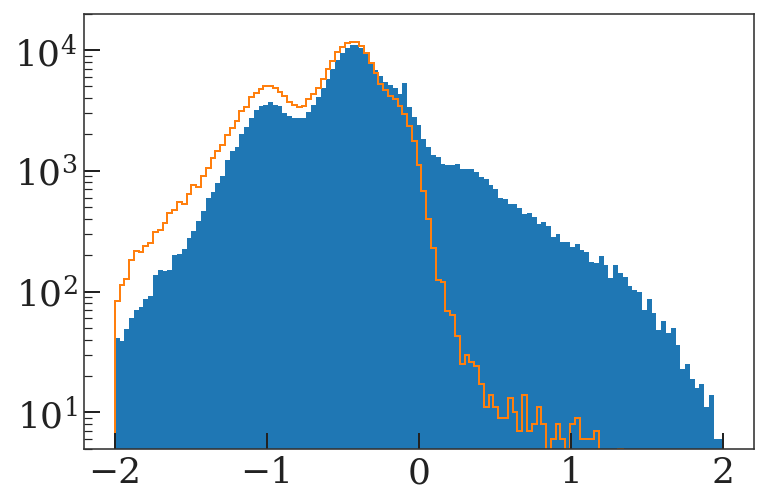

In [16]:
fig, ax = plt.subplots(1, 1, figsize=(6, 4))

bins = np.linspace(-2, 2, 128)
ax.hist(apogee_percentiles[:, 1], bins=bins, color='tab:blue')
ax.hist(control_percentiles[:, 1], bins=bins, color='tab:orange', 
        histtype='step', linestyle='-', linewidth=1);

ax.set_yscale('log')
ax.set_ylim(5, 2e4)

In [22]:
cut = 0.1
n_control = (control_percentiles[:, 1] > cut).sum()

percentile_mask = apogee_percentiles[:, 1] > cut
n_apogee = percentile_mask.sum()

print(n_control, n_apogee)
print(n_control / n_apogee)

841 22955
0.036636898279242


In [29]:
# apogee_ids = percentile_apogee_ids[percentile_mask]
# for apid in apogee_ids[:10]:
#     visits = allvisit[allvisit['APOGEE_ID'] == apid]
    
#     with h5py.File(node_paths['joker_results'], mode='r') as joker_f:
#         samples = tj.JokerSamples.read(joker_f[apid])
    
#     data = get_rvdata(visits)
    
#     plt.figure()
#     tj.plot_rv_curves(samples=samples, data=data)

In [24]:
metadata[percentile_mask].write('../catalogs/percentile_metadata.fits', overwrite=True)

In [25]:
percentile_samples_file = '../catalogs/percentile_samples.hdf5'

In [28]:
with tb.open_file(percentile_samples_file, 'w') as cat_f:
    with tb.open_file(c.mcmc_results_path, 'r') as mcmc_f, tb.open_file(c.joker_results_path, 'r') as joker_f:
        table = None
        for i, row in enumerate(tqdm(metadata[percentile_mask])):
            apid = row['APOGEE_ID']

            if row['mcmc_success']:
                f = mcmc_f
            else:
                f = joker_f
            
            if table is None:
                table = at.Table(f.root[f'{apid}/samples'].read())
                table['APOGEE_ID'] = np.array([apid] * len(table)).astype('S18')
                table['m_f'] = fast_mf(table['P']*u.day, table['K']*u.km/u.s, table['e']).to_value(u.Msun)
                cat_f.create_table('/', 'samples', obj=table.as_array())
                
            else:
                table = at.Table(f.root[f'{apid}/samples'].read())
                table['APOGEE_ID'] = np.array([apid] * len(table)).astype('S18')
                table['m_f'] = fast_mf(table['P']*u.day, table['K']*u.km/u.s, table['e']).to_value(u.Msun)
                cat_f.root['samples'].append(table.as_array())

100%|██████████| 22955/22955 [09:00<00:00, 42.43it/s] 
